In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv("uit_vsfc_data/train.csv", sep="\t")
val_df = pd.read_csv("uit_vsfc_data/dev.csv", sep="\t")
test_df = pd.read_csv("uit_vsfc_data/test.csv", sep="\t")

In [4]:
print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (11426, 3)
Val shape: (1583, 3)
Test shape: (3166, 3)


In [5]:
train_shape = train_df.shape
val_shape = val_df.shape
test_shape = test_df.shape

In [6]:
total = train_shape[0] + val_shape[0] + test_shape[0]

In [7]:
print(total)

16175


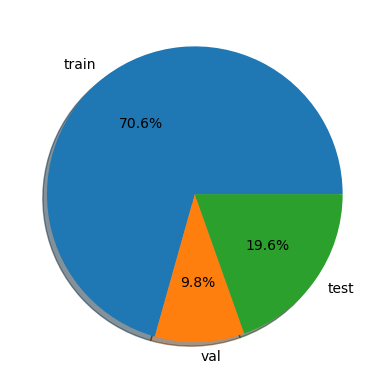

In [8]:
train_ratio = train_shape[0] / total
val_ratio = val_shape[0] / total
test_ratio = test_shape[0] / total

ratio = np.array([train_ratio, val_ratio, test_ratio])
label = ["train", "val", "test"]
plt.pie(ratio, labels=label, shadow=True, autopct='%1.1f%%')
plt.show()

In [9]:
train_df.columns

Index(['sents', 'sentiments', 'topics'], dtype='object')

In [10]:
df = pd.concat([train_df, val_df, test_df], axis=0)
print(df.shape)

(16175, 3)


In [11]:
s = df["sentiments"].value_counts()
print(s.index)
print(s.values)

Int64Index([2, 0, 1], dtype='int64')
[8038 7439  698]


In [12]:
ratio = (s.values / sum(s.values)) * 100

In [13]:
label = ["Negative", "Positive", "Neural"]

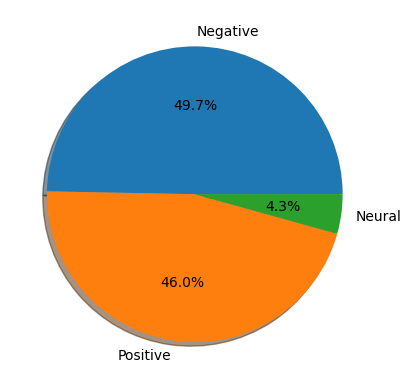

In [14]:
plt.pie(ratio, labels=label, shadow=True, autopct='%1.1f%%')
plt.show()

In [1]:
import torch
import config
from tqdm import tqdm
import numpy as np
from termcolor import colored

from models.phobert import UIT_VFSC_Dataset as BERTDataset
from models.phobert import collate_fn as BERTDataset_collate_fn
from models.fasttext_lstm import UIT_VFSC_Dataset as LSTMDataset
from models.fasttext_lstm import collate_fn as LSTMDataset_collate_fn
from models.fasttext_svm import converter

from models.phobert import PhoBertFeedForward_base, PhoBERTLSTM_base, PhoBERTModel
from models.fasttext_lstm import FastTextLSTMModel
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [43]:
def ensemble_fn(pred1, pred2):
    return pred1 * 0.8 + pred2 * 0.2

In [17]:
accuracy_fn = Accuracy(num_classes=config.NUM_CLASSES, average="weighted").to(config.DEVICE)
precision_fn = Precision(num_classes=config.NUM_CLASSES, average="weighted").to(config.DEVICE)
recall_fn = Recall(num_classes=config.NUM_CLASSES, average="weighted").to(config.DEVICE)
f1_fn = F1Score(num_classes=config.NUM_CLASSES, average="weighted").to(config.DEVICE)

In [3]:
phobert_testdata = BERTDataset(config.TEST_PATH)
phobert_testdataloader = DataLoader(dataset=phobert_testdata, batch_size=config.BATCH_SIZE,
                                    collate_fn=BERTDataset_collate_fn, shuffle=False,num_workers=config.NUM_WORKERS)

fasttext_lstm_testdata = LSTMDataset(config.TEST_PATH)
fasttext_lstm_testdataloader = DataLoader(dataset=fasttext_lstm_testdata, batch_size=config.BATCH_SIZE,
                                    collate_fn=LSTMDataset_collate_fn, shuffle=False,num_workers=config.NUM_WORKERS)

phobert_ff_ckpt = torch.load(config.PHOBERT_FF_CKPT, map_location=config.DEVICE)
fasttext_lstm_ckpt = torch.load(config.LSTM_CKPT, map_location=config.DEVICE)
# phobert_lstm_ckpt = torch.load(config.PHOBERT_LSTM_CKPT, map_location=config.DEVICE)

phobert_ff = PhoBertFeedForward_base(from_pretrained=False)
# phobert_lstm = PhoBERTLSTM_base(from_pretrained=False)

phobert_ff_system = PhoBERTModel(phobert_ff)
phobert_ff_system.load_state_dict(phobert_ff_ckpt["state_dict"])
phobert_ff_system.eval()
phobert_ff_system.to(config.DEVICE)

# phobert_lstm_system = PhoBERTModel(phobert_lstm)
# phobert_lstm_system.load_state_dict(phobert_lstm_ckpt["state_dict"])
# phobert_lstm_system.eval()
# phobert_lstm_system.to(config.DEVICE)

fasttext_lstm_system = FastTextLSTMModel()
fasttext_lstm_system.load_state_dict(fasttext_lstm_ckpt["state_dict"])
fasttext_lstm_system.eval()
fasttext_lstm_system.to(config.DEVICE)

FastTextLSTMModel(
  (model): FastTextLSTM(
    (lstm): LSTM(300, 300, bidirectional=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear): Linear(in_features=600, out_features=3, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
  (acc): Accuracy()
  (f1): F1Score()
  (precision_fn): Precision()
  (recall_fn): Recall()
)

In [4]:
acc_list = []
precision_list = []
recall_list = []
f1_list = []

# with torch.no_grad():
#     loop = tqdm(phobert_testdataloader)
#     for input_ids, attn_mask, label in loop:
#         phobert_ff_pred = phobert_ff_system(input_ids.to(config.DEVICE), attn_mask.to(config.DEVICE))
#         phobert_lstm_pred = phobert_lstm_system(input_ids.to(config.DEVICE), attn_mask.to(config.DEVICE))
        
#         ensemble_pred = ensemble_fn(phobert_ff_pred, phobert_lstm_pred)

#         accuracy_val = accuracy_fn(ensemble_pred, label)
#         precision_val = precision_fn(ensemble_pred, label)
#         recall_val = recall_fn(ensemble_pred, label)
#         f1_val = f1_fn(ensemble_pred, label)

#         acc_list.append(accuracy_val)
#         precision_list.append(precision_val)
#         recall_list.append(recall_val)
#         f1_list.append(f1_val)

#         loop.set_description("Working")

with torch.no_grad():
    loop1 = tqdm(phobert_testdataloader)
    loop2 = tqdm(fasttext_lstm_testdataloader)

    pred1 = []
    pred2 = []
    label1 = []
    label2 = []

    for input_ids, attn_mask, label in loop1:
        phobert_ff_pred = phobert_ff_system(input_ids.to(config.DEVICE), attn_mask.to(config.DEVICE))
        pred1.append(phobert_ff_pred)
        label1.append(label)
        loop1.set_description("Working on Model 1")


    for vec, label in loop2:
        fasttext_lstm_pred = fasttext_lstm_system(vec.to(config.DEVICE))
        pred2.append(fasttext_lstm_pred)
        label2.append(label)
        loop2.set_description("Working on Model 2")

  0%|          | 0/198 [00:00<?, ?it/s]Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/homebrew/Caskroom/miniforge/base/envs/torch_nightly/lib/python3.10/site-packages/transformers/models/roberta/modeling_roberta.py:1570: UserWarning: The operator 'aten::cumsum.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
Working on Model 2: 100%|██████████| 198/198 [03:04<00:00,  1.07it/s]


In [10]:
pred1 = torch.cat(pred1, dim=0)
pred2 = torch.cat(pred2, dim=0)

torch.Size([3166, 3])


In [50]:
ensemble_pred = ensemble_fn(pred1, pred2)
print(ensemble_pred.size())

torch.Size([3166, 3])


In [ ]:
label1 = torch.cat(label1)

In [51]:
accuracy_val = accuracy_fn(ensemble_pred.to(config.DEVICE), label1.to(config.DEVICE))
precision_val = precision_fn(ensemble_pred.to(config.DEVICE), label1.to(config.DEVICE))
recall_val = recall_fn(ensemble_pred.to(config.DEVICE), label1.to(config.DEVICE))
f1_val = f1_fn(ensemble_pred.to(config.DEVICE), label1.to(config.DEVICE))

print(colored(f"Accuracy: {accuracy_val:.4f}", "blue"))        
print(colored(f"Precision: {precision_val:.4f}", "blue"))        
print(colored(f"Recall: {recall_val:.4f}", "blue"))        
print(colored(f"F1-score: {f1_val:.4f}", "blue"))     

Accuracy: 0.9198
Precision: 0.9131
Recall: 0.9198
F1-score: 0.9127
